In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv("epldata_final.csv")

# Define age category function
def age_category(age):
    if age < 22:
        return 1
    elif age < 25:
        return 2
    elif age < 28:
        return 3
    elif age < 30:
        return 4
    elif age < 32:
        return 5
    else:
        return 6

In [3]:
# Data preprocessing
df['age_cat'] = df['age'].apply(age_category)
df['age_cat'] = pd.Categorical(df['age_cat'])
df['age_category'] = pd.cut(df['age'], bins=[16, 21, 25, 28, 31, 38], labels=["17-21", "22-25", "26-28", "29-31", "32-38"])

In [4]:
# Preliminary analysis
most_valuable_players = df.sort_values(by='market_value', ascending=False).head(6)
most_popular_players = df.sort_values(by='page_views', ascending=False).head(6)

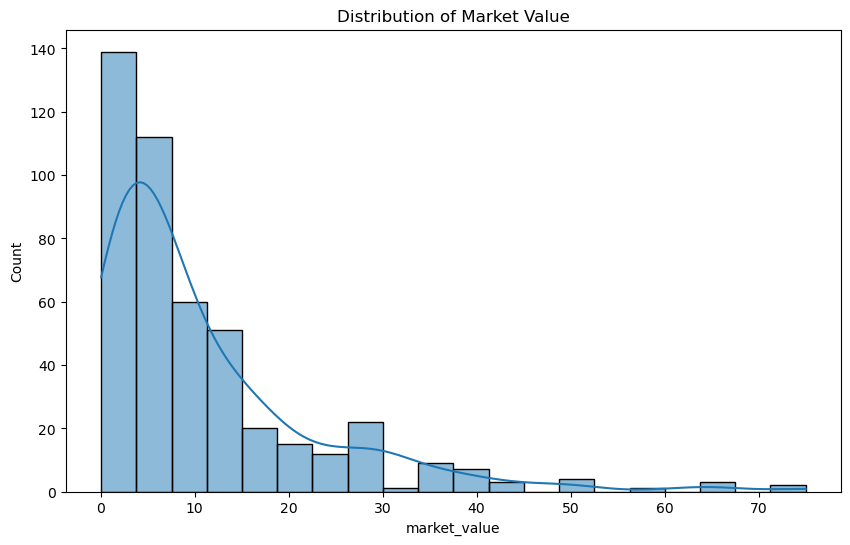

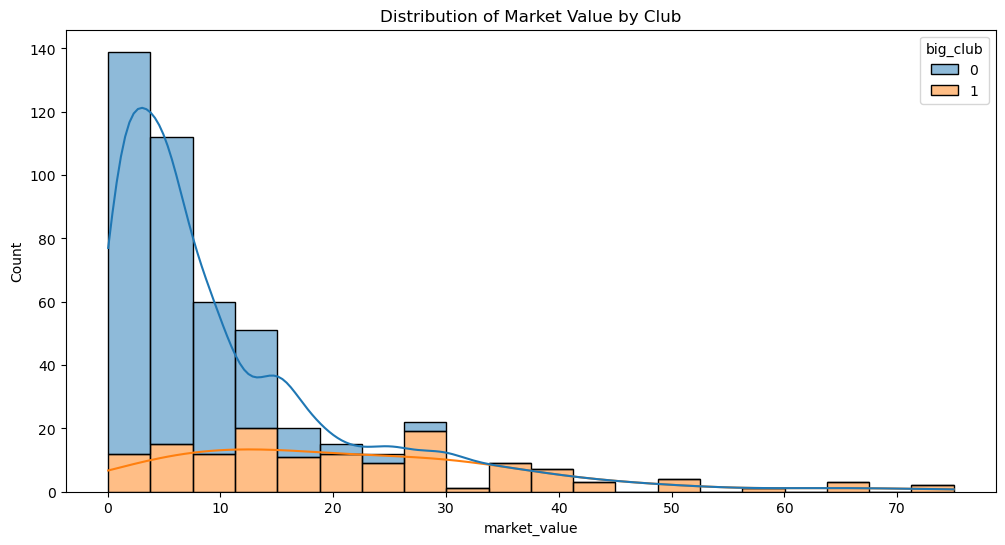

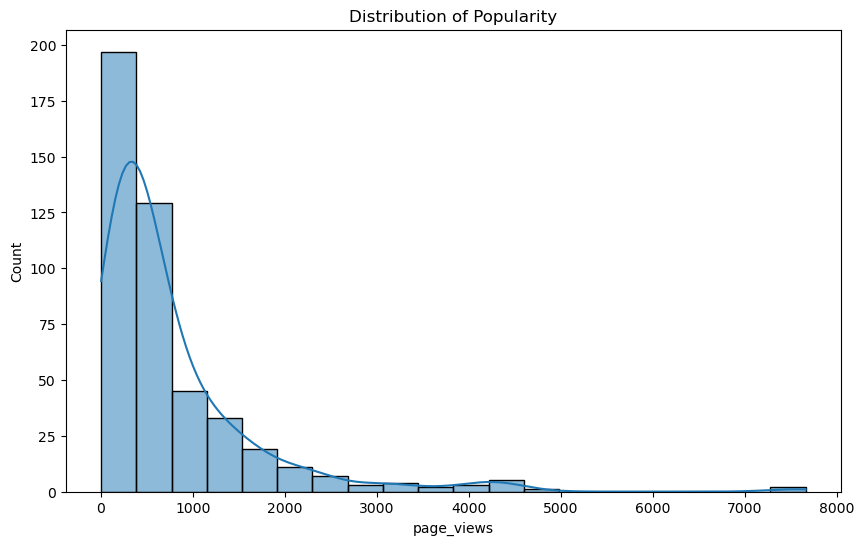

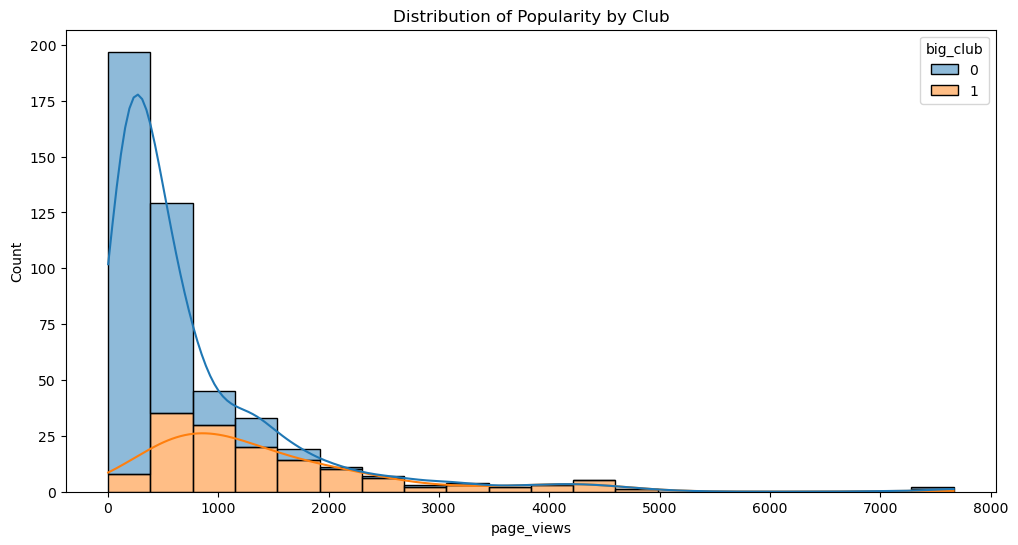

In [5]:
# Distribution of Market Value
plt.figure(figsize=(10, 6))
sns.histplot(df['market_value'], bins=20, kde=True)
plt.title('Distribution of Market Value')
plt.show()

# Distribution of Market Value by Club
plt.figure(figsize=(12, 6))
sns.histplot(df, x='market_value', bins=20, hue='big_club', multiple='stack', kde=True)
plt.title('Distribution of Market Value by Club')
plt.show()

# Distribution of Popularity
plt.figure(figsize=(10, 6))
sns.histplot(df['page_views'], bins=20, kde=True)
plt.title('Distribution of Popularity')
plt.show()

# Distribution of Popularity by Club
plt.figure(figsize=(12, 6))
sns.histplot(df, x='page_views', bins=20, hue='big_club', multiple='stack', kde=True)
plt.title('Distribution of Popularity by Club')
plt.show()

Clearly not a normal distribution, but this was expected. Teams tend to have few elite players, and a large number of low + mid value players in their squads. An analysis of a team’s 1st 15 would probably look more like a normal distribution, since we’d be excluding low value fringe / youth players.

Interesting. The top 6 seem to have a spread of players, whereas the others have a large majority of players worth under 10 million (transfermrkt’s valuation, not mine).

Similar distribution to market value, except the 2 outliers at the end - Wayne Rooney and Paul Pogba. While Rooney is already the most well-known (popular is debatable) current English footballer, he also happened to break Sir Bobby Charlton’s record of most goals for Manchester United. This, alongside the constant speculation over his United career, definitely led to his heightened page views. Paul Pogba, on the other hand, is a combination of intense scrutiny (of being the world’s most expensive transfer), a return to Manchester United (can definitely see people looking him up for that), and also the fact that he is a very marketable, visible player.
Again, the top 6 clubs seem to have a spread of players popularity. Also, Wayne Rooney is at Everton now.

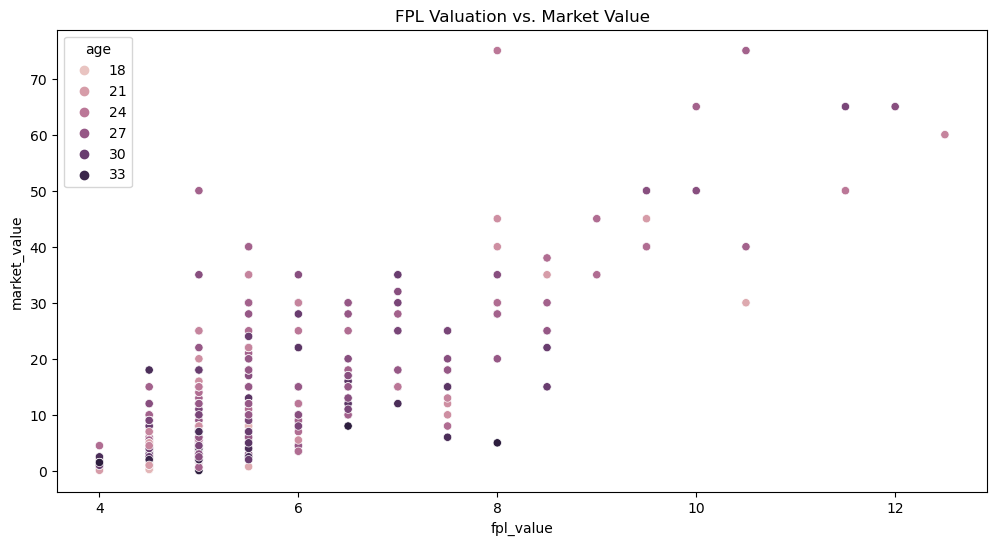

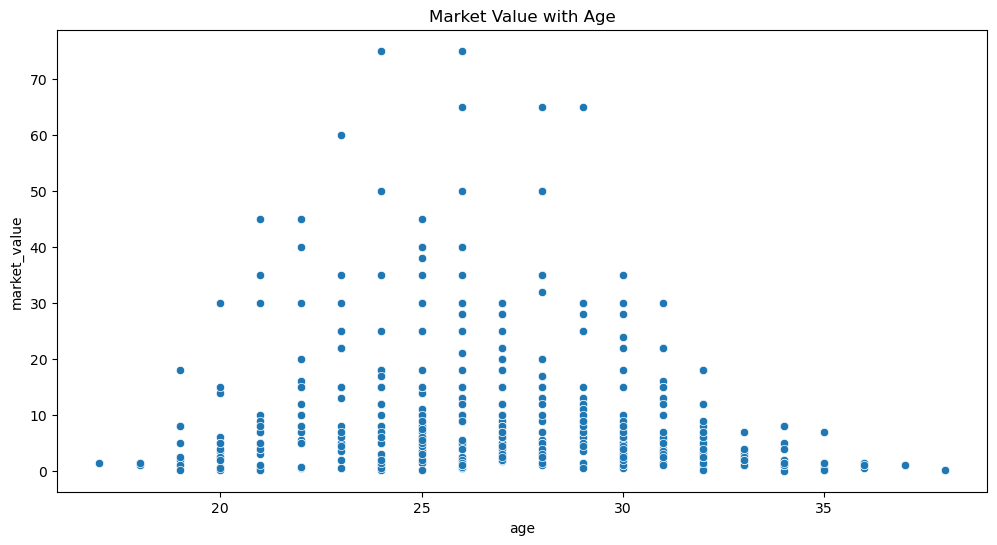

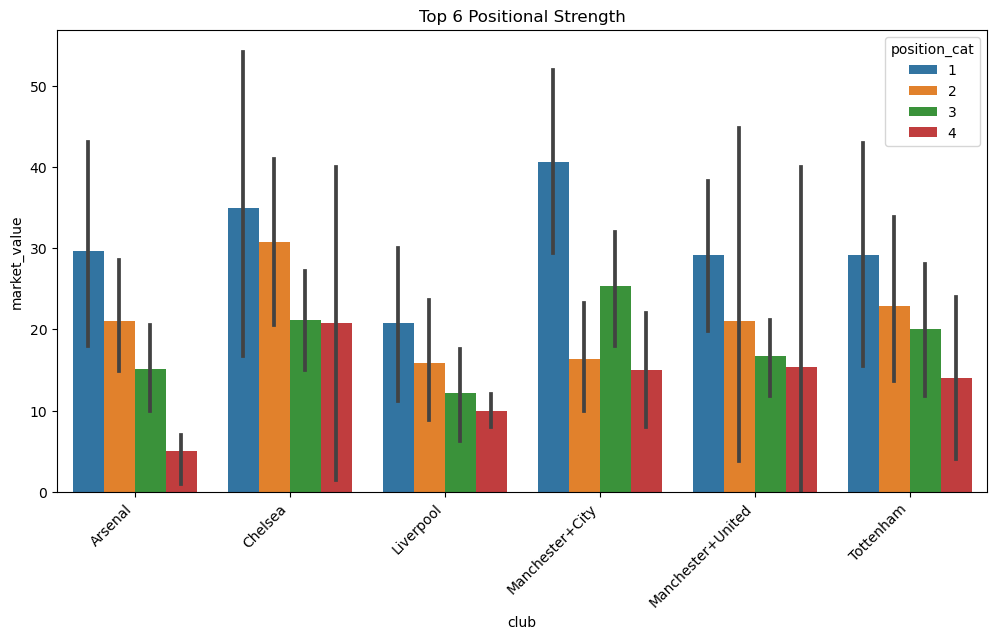

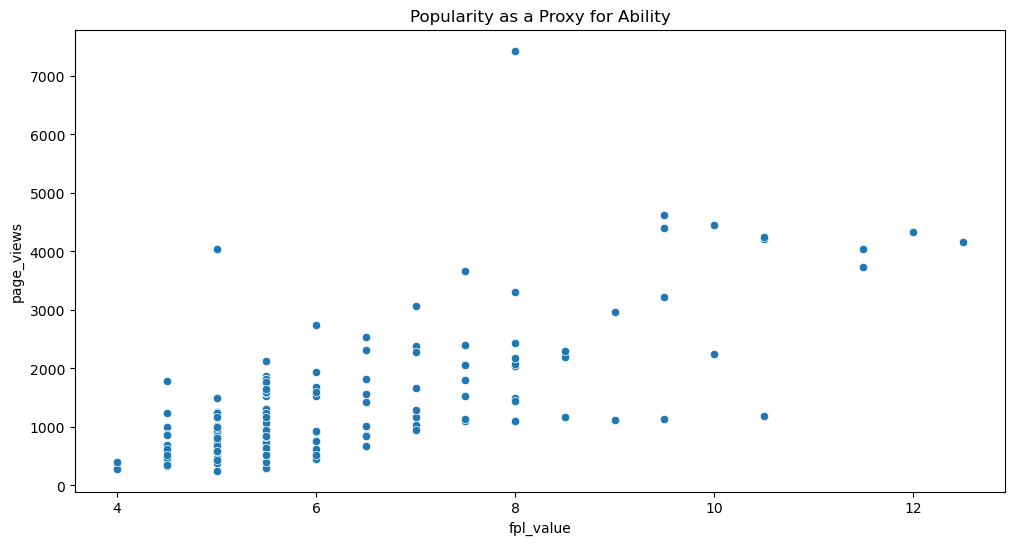

In [6]:
# Detailed Analysis
# FPL Valuation
plt.figure(figsize=(12, 6))
sns.scatterplot(x='fpl_value', y='market_value', hue='age', data=df[df['age'] < 35])
plt.title('FPL Valuation vs. Market Value')
plt.show()

# Market Value with Age
plt.figure(figsize=(12, 6))
sns.scatterplot(x='age', y='market_value', data=df)
plt.title('Market Value with Age')
plt.show()

# Top 6 Positional Strength
plt.figure(figsize=(12, 6))
df_top6_pos = df[df['club_id'].isin([1, 5, 10, 11, 12, 17])]
sns.barplot(x='club', y='market_value', hue='position_cat', data=df_top6_pos)
plt.title('Top 6 Positional Strength')
plt.xticks(rotation=45, ha='right')
plt.show()

# Popularity as a proxy for Ability
plt.figure(figsize=(12, 6))
sns.scatterplot(x='fpl_value', y='page_views', data=df[df['club_id'].isin([1, 5, 10, 11, 12, 17])])
plt.title('Popularity as a Proxy for Ability')
plt.show()

Clearly, the case I’m trying to build is that there seems to be evidence of a player’s market value being correlated with how popular he is. This is interesting because ability and performance are notoriously difficult to quantify in football. It varies with the position, the manager’s tactics, the opposition, the league, the ability of your own teammates, and so on. Consequently, valuing a player is very hard to do, though it has to be done anyway.
Websites like WhoScored have a score for each player for each match, and Fantasy Premier League places a value on each player’s head. It would be interesting to see if popularity can be used as a basic proxy for ability, which is what I’ll attempt through a regression model.

There seems to be nice agreement between the FPL value and transfermrkt value, despite the fact that FPL valuation is decidedly shorter term, so age would be less of a factor. I was expecting to see more players in the bottom right - older players with low market value, but high FPL value, theoretically like Petr Cech and Yaya Toure. Maybe there’s a better way of highlighting that.

This seems about right. If FPL valuation were equivalent to transfer market value, we’d see a constant ratio, across age groups. But the fact that the lowest FPL value is 4 million, very young and unproven players have a low ratio. Similarly, at the other end old players have very low market values, but they may still be valuable over the next season.
What’s interesting is how the ratio for forwards falls off a cliff beyond 32, possibly implying very low market valuations for them.

It is fairly intuitive that older players will, on average, have lower market values. A rough illustration - The high value players are clustered around the age of 24-32, peaking at about 27. It’s important to note that this is in no way a linear relationship, which is why I use age categories in the regression model that follows. An alternative would be to do a change-point regression, which means building 2 models, one where age < threshold, one where age >= threshold.

Who’s stocking up at which position?
Manchester City have forwards and attacking midfielders with huge potential, but their defence is very weak (not since Mendy, Walker and Danilo arrived - but they aren’t in this dataset). How do each of the top 6 stack up, in terms of positional strength?

As explained in the next section, we test the hypothesis that there is a relationship between ability and popularity. Ability is difficult to measure and compare through performance indicators. For the purpose of this section, I assume FPL valuation is a fair measure of ability. While this may not be perfect, we should still be able to se a relationship between ability and popularity.

There seems to be a nice, linear relationship between FPL valuation and popularity, with a few notable exceptions (Wayne Rooney, sigh). Wonderful! This will help in the model below.

In [7]:
# Regression Model
df_model = df[~df['club_id'].isin([3, 8, 13]) & (df['new_foreign'] == 0)]
df_model['age_cat'] = pd.Categorical(df_model['age_cat'])
df_model['region'] = pd.Categorical(df_model['region'])
df_model['big_club'] = np.where(df_model['club_id'].isin([1, 5, 10, 11, 12, 17]), 1, 0)

# Square root transformation
df_model['sqrt_market_value'] = np.sqrt(df_model['market_value'])
df_model['sqrt_page_views'] = np.sqrt(df_model['page_views'])

# Multiple linear regression
model = sm.OLS(df_model['sqrt_market_value'], sm.add_constant(df_model[['sqrt_page_views', 'age_cat', 'position_cat', 'region', 'big_club']]))
results = model.fit()

# Print R-squared
print(f'R-squared: {results.rsquared}')

C:\Users\shaki\AppData\Local\Temp\ipykernel_5884\3918595280.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['age_cat'] = pd.Categorical(df_model['age_cat'])
C:\Users\shaki\AppData\Local\Temp\ipykernel_5884\3918595280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['region'] = pd.Categorical(df_model['region'])
C:\Users\shaki\AppData\Local\Temp\ipykernel_5884\3918595280.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

R-squared: 0.5927953783643287


The main aim is to see whether market value can be determined using popularity as a proxy for ability. A player’s market value can intuitively be represented as -

market value ~ ability + position + age

The last 2 are easily observable, but ability is a difficult attribute to measure. There are a variety of metrics used for this, but I’ve decided to use a simple proxy for it - popularity (or more specifically, Wikipedia page views over the last year). I chose Wikipedia views for the following reasons -

Better than Twitter/Facebook since it’s not dependent on whether the player has a profile or not.

Better than Facebook/Instagram followers since those are subject to how engaging the players’ posts are, as well.

Was easy to get for the timeframe required - I wanted to exclude May - July, since it would inflate the popularity of players linked with a transfer in 2016/17.



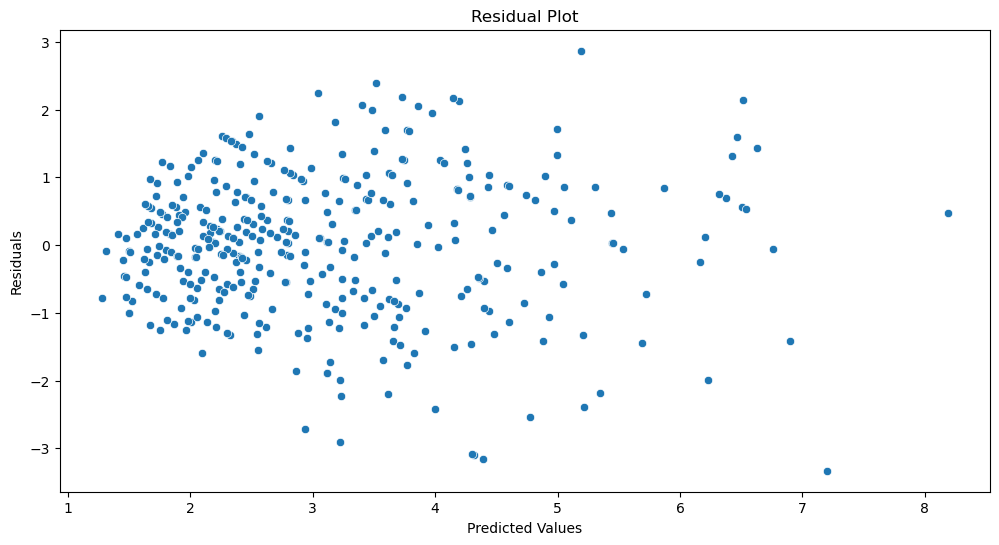

In [8]:
# Residual plots
residuals = results.resid
predicted_values = results.predict()
plt.figure(figsize=(12, 6))
sns.scatterplot(x=predicted_values, y=residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

<Figure size 1200x600 with 0 Axes>

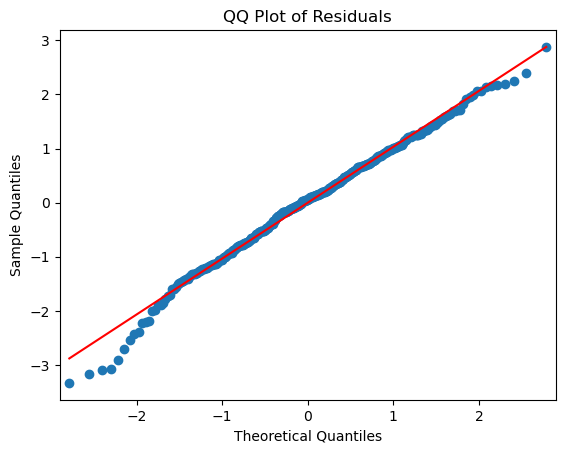

In [9]:
plt.figure(figsize=(12, 6))
sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()

The residual plot seems to have randomly distributed errors, and the qq plot confirms that they are normally distributed.